# Step 1: Data Exploration and Preprocessing

In [1]:
# pip install torchvision

In [2]:
# Importing libraries
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch.nn as nn

In [3]:
# Define transformations for data augmentation and normalization
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalizing to [-1, 1] range
])

In [4]:
# Load CIFAR-10 dataset with transformations
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# Access class names
classes = trainset.classes
print("Classes in CIFAR-10 dataset:", classes)


Files already downloaded and verified
Classes in CIFAR-10 dataset: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


## Exploratory Data Analysis

Class distribution in CIFAR-10 training set:
frog: 5000
truck: 5000
deer: 5000
automobile: 5000
bird: 5000
horse: 5000
ship: 5000
cat: 5000
dog: 5000
airplane: 5000


/tmp/ipykernel_13727/1647909903.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(class_counts_named.keys()), y=list(class_counts_named.values()), palette="viridis")


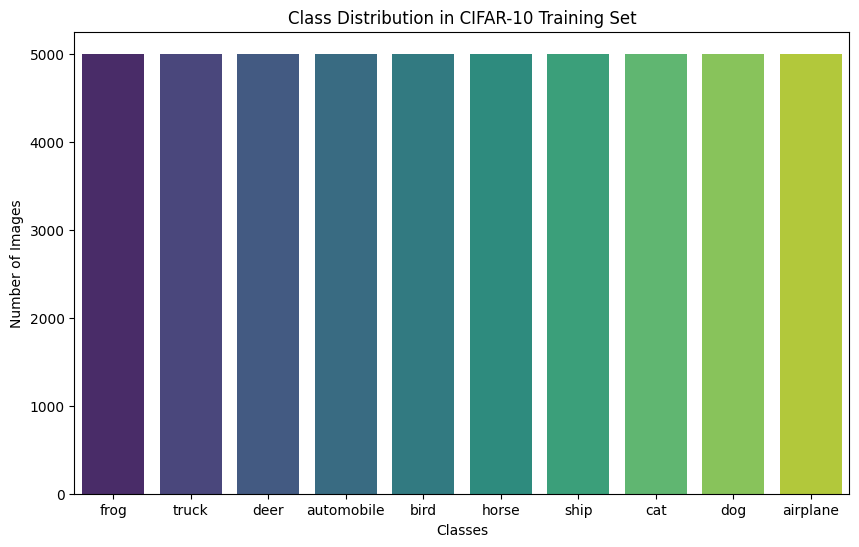

In [5]:
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

# Get the labels for each image in the training set
train_labels = [label for _, label in trainset]

# Count the occurrences of each class
class_counts = Counter(train_labels)

# Map the class indices to class names
class_names = trainset.classes
class_counts_named = {class_names[i]: count for i, count in class_counts.items()}

# Display the class distribution
print("Class distribution in CIFAR-10 training set:")
for class_name, count in class_counts_named.items():
    print(f"{class_name}: {count}")

# Plot the class distribution
plt.figure(figsize=(10, 6))
sns.barplot(x=list(class_counts_named.keys()), y=list(class_counts_named.values()), palette="viridis")
plt.title("Class Distribution in CIFAR-10 Training Set")
plt.xlabel("Classes")
plt.ylabel("Number of Images")
plt.show()

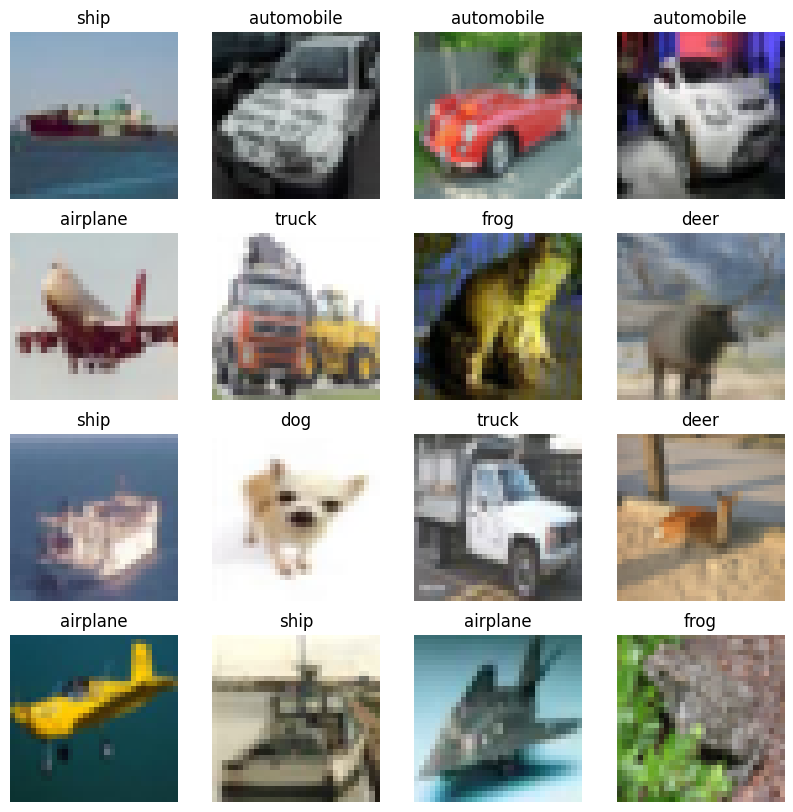

In [6]:
# Function to display a grid of sample images
def show_images(dataset, num_images=16):
    loader = torch.utils.data.DataLoader(dataset, batch_size=num_images, shuffle=True)
    data_iter = iter(loader)
    images, labels = next(data_iter)

    # Unnormalize images for display
    images = images / 2 + 0.5
    np_images = images.numpy()

    # Plot images
    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        plt.subplot(4, 4, i + 1)
        plt.imshow(np.transpose(np_images[i], (1, 2, 0)))
        plt.title(classes[labels[i]])
        plt.axis("off")
    plt.show()

# Display sample images from the training set
show_images(trainset)

In [7]:
# Get image shape
image_shape = trainset[0][0].shape
print(f"Each image has dimensions: {image_shape}")

Each image has dimensions: torch.Size([3, 32, 32])


In [8]:
# Function to calculate mean and std across channels
def get_mean_std(dataset):
    loader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=False)
    mean = 0.0
    std = 0.0
    total_images = 0
    for images, _ in loader:
        batch_samples = images.size(0)  # Batch size (number of images in each batch)
        images = images.view(batch_samples, images.size(1), -1)  # Reshape to [batch, channels, pixels]
        mean += images.mean(2).sum(0)  # Sum mean per channel
        std += images.std(2).sum(0)  # Sum std per channel
        total_images += batch_samples

    mean /= total_images
    std /= total_images
    return mean, std

# Calculate and print mean and std
mean, std = get_mean_std(trainset)
print(f"Mean: {mean}")
print(f"Standard Deviation: {std}")

Mean: tensor([-0.0172, -0.0357, -0.1069])
Standard Deviation: tensor([0.4046, 0.3988, 0.4019])


# Preprocessing - converting images into pytorch tensors

In [9]:
# Load CIFAR-10 dataset with transformations
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_size = int(0.9 * len(trainset))
val_size = len(trainset) - train_size
trainset, valset = torch.utils.data.random_split(trainset, [train_size, val_size])

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=False)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


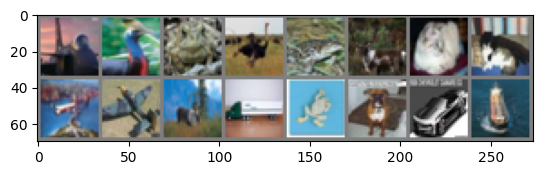

In [10]:
# Class names in CIFAR-10
classes = trainset.dataset.classes

# Visualize a few images
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Show images and labels
imshow(torchvision.utils.make_grid(images[:16]))

# Step 2: Building a Basic CNN

In [11]:
import torch.nn as nn
import torch.optim as optim

# Define CNN architecture
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 10)
        
    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 64 * 8 * 8)  # Flatten layer
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Instantiate the model
model = SimpleCNN()

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [12]:
# pip install torchsummary

In [13]:
from torchsummary import summary

# Move model to device (if using GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Print model summary
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
         MaxPool2d-2           [-1, 32, 16, 16]               0
            Conv2d-3           [-1, 64, 16, 16]          18,496
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Linear-5                  [-1, 128]         524,416
            Linear-6                   [-1, 10]           1,290
Total params: 545,098
Trainable params: 545,098
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.47
Params size (MB): 2.08
Estimated Total Size (MB): 2.56
----------------------------------------------------------------


# Step 3: Model Training and Evaluation

In [14]:
import torch
from torch.utils.data import DataLoader

# Define dataloaders
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
valloader = DataLoader(valset, batch_size=64, shuffle=False)

# Training and validation loop
num_epochs = 10
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    
    # Training
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward + backward + optimize
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        # Calculate training accuracy
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)
    
    train_losses.append(running_loss / len(trainloader))
    train_accuracies.append(100 * correct_train / total_train)
    
    # Validation
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in valloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            
            # Calculate validation accuracy
            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)
    
    val_losses.append(val_loss / len(valloader))
    val_accuracies.append(100 * correct_val / total_val)
    
    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Training Loss: {train_losses[-1]:.4f}, Training Accuracy: {train_accuracies[-1]:.2f}%, "
          f"Validation Loss: {val_losses[-1]:.4f}, Validation Accuracy: {val_accuracies[-1]:.2f}%")

Epoch [1/10], Training Loss: 1.3678, Training Accuracy: 50.66%, Validation Loss: 1.0815, Validation Accuracy: 61.68%
Epoch [2/10], Training Loss: 0.9910, Training Accuracy: 65.30%, Validation Loss: 0.9213, Validation Accuracy: 67.40%
Epoch [3/10], Training Loss: 0.8407, Training Accuracy: 70.55%, Validation Loss: 0.8676, Validation Accuracy: 69.50%
Epoch [4/10], Training Loss: 0.7315, Training Accuracy: 74.23%, Validation Loss: 0.8234, Validation Accuracy: 71.36%
Epoch [5/10], Training Loss: 0.6347, Training Accuracy: 77.86%, Validation Loss: 0.8411, Validation Accuracy: 71.26%
Epoch [6/10], Training Loss: 0.5475, Training Accuracy: 80.71%, Validation Loss: 0.8415, Validation Accuracy: 71.66%
Epoch [7/10], Training Loss: 0.4662, Training Accuracy: 83.58%, Validation Loss: 0.8533, Validation Accuracy: 71.82%
Epoch [8/10], Training Loss: 0.3876, Training Accuracy: 86.51%, Validation Loss: 0.9294, Validation Accuracy: 71.86%
Epoch [9/10], Training Loss: 0.3244, Training Accuracy: 88.63%, 

## Visualize the Training Process

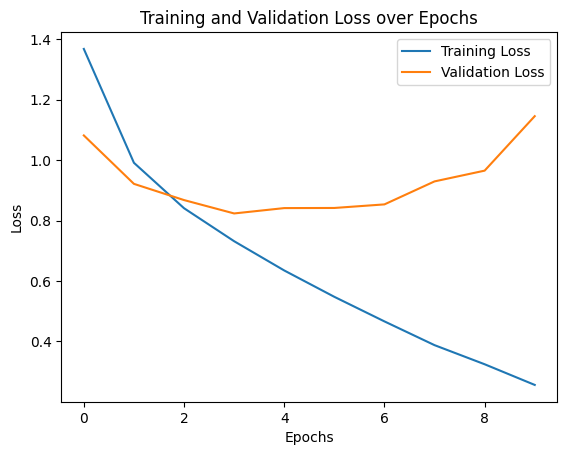

In [15]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss over Epochs")
plt.legend()
plt.show()

Accuracy: 0.7129
Precision: 0.7208
Recall: 0.7129
F1 Score: 0.7129


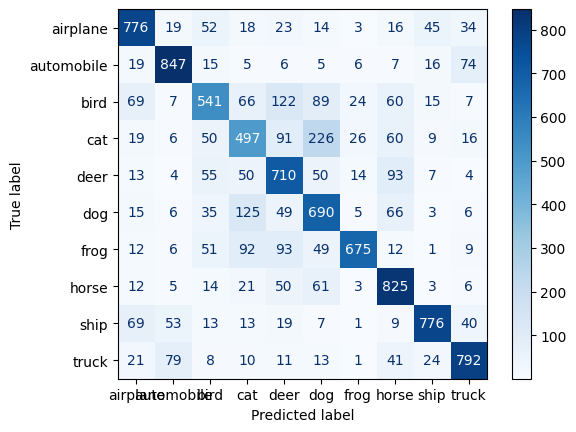

In [16]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

# After evaluating your model on the test set and obtaining predictions and true labels
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        
        all_preds.extend(predicted.cpu().numpy())  # Collect predictions
        all_labels.extend(labels.cpu().numpy())    # Collect true labels

# Convert to numpy arrays for sklearn functions
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Calculate accuracy, precision, recall, and F1-score
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average="macro")
recall = recall_score(all_labels, all_preds, average="macro")
f1 = f1_score(all_labels, all_preds, average="macro")

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Confusion Matrix
confusion_mat = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_mat, display_labels=classes)  # Use the class names
disp.plot(cmap='Blues')

# Step 4: Model Improvement

In [18]:
# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the Improved CNN Model
class ImprovedCNN(nn.Module):
    def __init__(self):
        super(ImprovedCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.fc1 = nn.Linear(128 * 4 * 4, 256)
        self.fc2 = nn.Linear(256, 10)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool(torch.relu(self.bn2(self.conv2(x))))
        x = self.pool(torch.relu(self.bn3(self.conv3(x))))
        x = x.view(-1, 128 * 4 * 4)
        x = self.dropout(torch.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

# Instantiate the model, define loss function and optimizer
model = ImprovedCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# Define the learning rate scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

# Initialize lists to keep track of losses and accuracies
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# Early stopping parameters
best_val_loss = float('inf')
patience = 5
patience_counter = 0

# Training Loop
num_epochs = 30
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Calculate running loss and accuracy
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Calculate average training loss and accuracy
    avg_train_loss = running_loss / len(trainloader)
    train_accuracy = 100 * correct / total

    # Store training loss and accuracy
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)

    # Validation Loop
    model.eval()  # Set the model to evaluation mode
    running_val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()

            # Calculate validation accuracy
            _, val_predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (val_predicted == labels).sum().item()

    # Calculate average validation loss and accuracy
    avg_val_loss = running_val_loss / len(testloader)
    val_accuracy = 100 * val_correct / val_total

    # Store validation loss and accuracy
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

    # Print results in the desired format
    print(f"Epoch [{epoch + 1}/{num_epochs}], "
          f"Training Loss: {avg_train_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%, "
          f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    # Step the scheduler after the epoch
    scheduler.step()

    # Early stopping check
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        # Optionally save the model
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print("Early stopping triggered!")
        break

# Final Evaluation on Test Set
model.eval()  # Set the model to evaluation mode
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Final Accuracy of the model on the 10,000 test images: {100 * correct / total:.2f}%')

Epoch [1/30], Training Loss: 1.4348, Training Accuracy: 47.52%, Validation Loss: 1.0801, Validation Accuracy: 61.00%
Epoch [2/30], Training Loss: 1.0983, Training Accuracy: 60.89%, Validation Loss: 0.8836, Validation Accuracy: 68.52%
Epoch [3/30], Training Loss: 0.9663, Training Accuracy: 66.21%, Validation Loss: 0.9561, Validation Accuracy: 66.48%
Epoch [4/30], Training Loss: 0.8754, Training Accuracy: 69.28%, Validation Loss: 0.7965, Validation Accuracy: 71.98%
Epoch [5/30], Training Loss: 0.8029, Training Accuracy: 72.11%, Validation Loss: 0.7723, Validation Accuracy: 72.63%
Epoch [6/30], Training Loss: 0.6738, Training Accuracy: 76.49%, Validation Loss: 0.6759, Validation Accuracy: 76.45%
Epoch [7/30], Training Loss: 0.6290, Training Accuracy: 77.92%, Validation Loss: 0.6488, Validation Accuracy: 77.71%
Epoch [8/30], Training Loss: 0.5931, Training Accuracy: 79.24%, Validation Loss: 0.6574, Validation Accuracy: 77.24%
Epoch [9/30], Training Loss: 0.5562, Training Accuracy: 80.29%, 

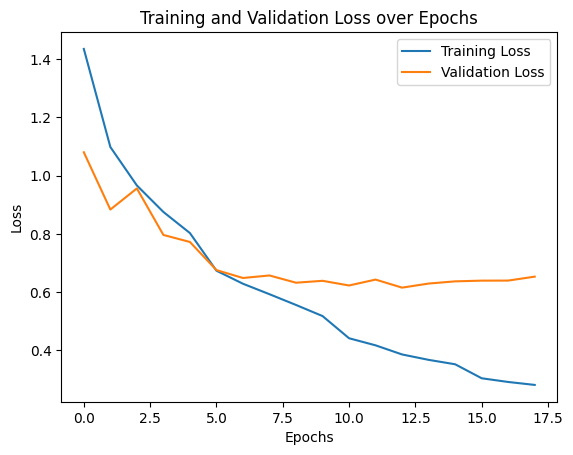

In [19]:
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss over Epochs")
plt.legend()
plt.show()